  #             Predicting the Survival of Titanic Passengers 

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
#algorithms
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler,LabelEncoder
from scipy.stats import levene
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import GaussianNB

 # loading data:

In [3]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

In [4]:
#data exploration:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


The training-set has 891 examples and 11 features + the target variable (survived).
2 of the features are floats, 5 are integers and 5 are objects.

# description:
survival:    Survival 
PassengerId: Unique Id of a passenger        
pclass:    Ticket class     
sex:    Sex     
Age:    Age in years     
sibsp:    # of siblings / spouses aboard the Titanic     
parch:    # of parents / children aboard the Titanic     
ticket:    Ticket number     
fare:    Passenger fare     
cabin:    Cabin number     
embarked:    Port of Embarkation

In [7]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Above we can see that 38% out of the training-set survived the Titanic. We can also see that the passenger
ages range from 0.4 to 80. On top of that we can already detect some features, that contain missing values,
like the ‘Age’ feature.

In [8]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


we need to convert a lot of features into numeric ones later on, so that the machine learning algorithms can process them.
Furthermore, we can see that the features have widely different ranges, that we will need to convert into roughly the same 
scale. We can also spot some more features, that contain missing values (NaN = not a number), that wee need to deal with.

In [9]:
#checking for missing values
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [11]:
#percentage of cabin missing values
train_df['Cabin'].isnull().sum()/train_df['Cabin'].isnull().count()*100

77.10437710437711

The Embarked feature has only 2 missing values, which can easily be filled. We to deal with the ‘Age’ feature, which has 177 missing values. The ‘Cabin’ feature needs further investigation, but it looks like that we might want to drop it from the dataset, since 77 % of it are missing.

# EDA:

Text(0.5, 1.0, 'Male')

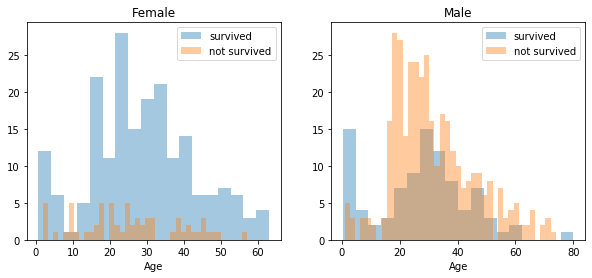

In [17]:
#Commparing Age and Sex
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
ax.set_title('Male')

You can see that men have a high probability of survival when they are between 18 and 30 years old, which is also a little bit true for women but not fully. For women the survival chances are higher between 14 and 40.
For men the probability of survival is very low between the age of 5 and 18, but that isn’t true for women. Another thing to note is that infants also have a little bit higher probability of survival.

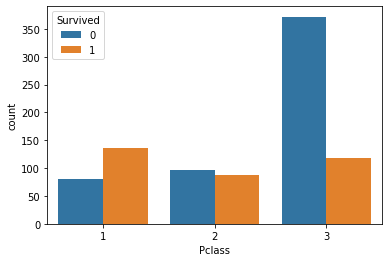

In [5]:
#pclass
sns.countplot(x='Pclass', hue='Survived', data=train_df)

Here we see clearly, that Pclass is contributing to a persons chance of survival, especially if this person is in class 1.
 we can also spot a high probability that a person in pclass 3 will not survive.

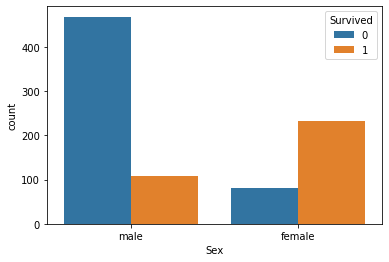

In [6]:
#sex
sns.countplot(x='Sex',hue='Survived',data=train_df)

female survived more than men.

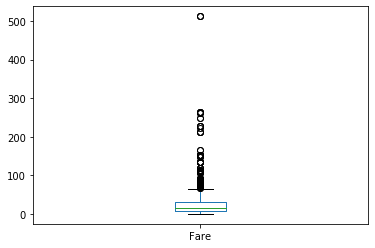

In [22]:
#Fare
train_df.Fare.plot(kind='box')

we can see a lot of outliers here and the max fare paid is approx rs.500

In [25]:
print('skewness for age : {0:.2f}'.format(train_df.Age.skew()))
print('skewness for fare : {0:.2f}'.format(train_df.Fare.skew()))

skewness for age : 0.39
skewness for fare : 4.79


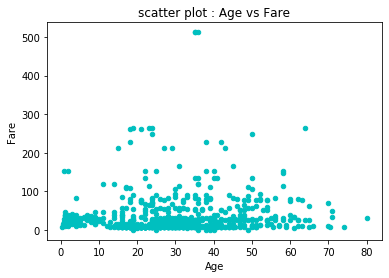

In [27]:
#age vs fare
train_df.plot.scatter(x='Age', y='Fare', color='c', title='scatter plot : Age vs Fare');

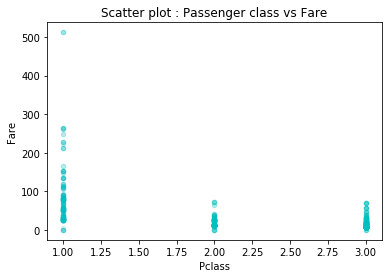

In [28]:
#pclass vs fare
train_df.plot.scatter(x='Pclass', y='Fare', color='c', title='Scatter plot : Passenger class vs Fare', alpha=0.15);

# Data preprocessing:
Dropping 'PassengerId','Name','Ticket' from the train set, because it does not contribute to a persons survival probability.

In [42]:
train_df = train_df.drop(['Name','PassengerId','Cabin','Ticket'], axis=1)

In [43]:
#age
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)
train_df["Age"].isnull().sum()

0

#Embarked:
Since the Embarked feature has only 2 missing values, we will just fill these with the most common one.

In [44]:
train_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [45]:
data = [train_df, test_df]
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [46]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null int32
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null object
dtypes: float64(1), int32(1), int64(4), object(2)
memory usage: 52.3+ KB


In [47]:
#converting sex to int by mapping
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

In [48]:
#converting embarked to int by mapping
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [49]:
#creating a new column called Age per pclass:
data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

In [50]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Class
0,0,3,0,22,1,0,7.2500,0,66
1,1,1,1,38,1,0,71.2833,1,38
2,1,3,1,26,0,0,7.9250,0,78
3,1,1,1,35,1,0,53.1000,0,35
4,0,3,0,35,0,0,8.0500,0,105


In [52]:
test_df.drop(columns=['Name','Ticket','Cabin'],inplace=True)

In [56]:
test_df['Fare'].fillna(test_df['Fare'].median(),inplace=True)

# Building models:

In [57]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()

In [71]:
m1 = LogisticRegression()
knn = KNeighborsClassifier() 
DT = DecisionTreeClassifier()
RF = RandomForestClassifier(n_estimators=100)
NB = GaussianNB()
bag = BaggingClassifier(n_estimators=10)
adaboost = AdaBoostClassifier(n_estimators=50)
adaboost_rf = AdaBoostClassifier(base_estimator=RF,n_estimators=50)
grad = GradientBoostingClassifier(n_estimators=35)   

models = []
models.append(('Logistic Regression',m1))
models.append(('KNN',knn))
models.append(('Decision Tree',DT))
models.append(('Random Forrest',RF))
models.append(('GaussianNB',NB))
models.append(('Bagged DT',bag))
models.append(('Ada Boost DT',adaboost))
models.append(('Ada boost Random Forrest',adaboost_rf))
models.append(('Gradient boosting',grad))

results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=5,shuffle=True,random_state=0)
    auc = model_selection.cross_val_score(model,X_train,Y_train,cv=kfold,scoring='roc_auc')
    results.append(auc)
    names.append(name)
    print('%s: %f' % (name,np.mean(auc*100)))
    BE =1-np.mean(auc)#Bias error
    VE =np.var(1-auc,ddof=1)#variance error
    print("\t\tBais error : ", BE)
    print("\t\tVariance error: ",VE)

In [72]:
models = []
models.append(('Logistic Regression',m1))
models.append(('KNN',knn))
models.append(('Decision Tree',DT))
models.append(('Random Forrest',RF))
models.append(('GaussianNB',NB))
models.append(('Bagged DT',bag))
models.append(('Ada Boost DT',adaboost))
models.append(('Ada boost Random Forrest',adaboost_rf))
models.append(('Gradient boosting',grad))

In [73]:
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=5,shuffle=True,random_state=0)
    auc = model_selection.cross_val_score(model,X_train,Y_train,cv=kfold,scoring='roc_auc')
    results.append(auc)
    names.append(name)
    print('%s: %f' % (name,np.mean(auc*100)))
    BE =1-np.mean(auc)#Bias error
    VE =np.var(1-auc,ddof=1)#variance error
    print("\t\tBais error : ", BE)
    print("\t\tVariance error: ",VE)

Logistic Regression: 85.605588
		Bais error :  0.14394411615507785
		Variance error:  0.0005057489614507518
KNN: 69.544851
		Bais error :  0.3045514907992297
		Variance error:  0.0019234758151777922
Decision Tree: 76.267083
		Bais error :  0.23732917097966477
		Variance error:  0.001164915126133318
Random Forrest: 86.075502
		Bais error :  0.13924497904183541
		Variance error:  0.0005132167953866508
GaussianNB: 84.157665
		Bais error :  0.15842334936204772
		Variance error:  0.0005314667708157974
Bagged DT: 84.915771
		Bais error :  0.15084229383119907
		Variance error:  0.0005591323451687501
Ada Boost DT: 84.880817
		Bais error :  0.15119183293288108
		Variance error:  0.001203200554538963
Ada boost Random Forrest: 84.373147
		Bais error :  0.1562685305557805
		Variance error:  0.000941433319069133
Gradient boosting: 86.927077
		Bais error :  0.1307292318040677
		Variance error:  0.000825680230680998


In [69]:
from sklearn.model_selection import RandomizedSearchCV
# grid search
n_estimators = range(1, 100)
param_grid = dict(n_estimators=n_estimators)
r_search = RandomizedSearchCV(grad, param_grid,scoring="neg_log_loss", n_jobs=-1, cv=5)
r_search.fit(X_train,Y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

In [70]:
r_search.best_params_

{'n_estimators': 35}

In [74]:
grad.fit(X_train,Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=35,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

# Prediction:

In [98]:
y_pred = grad.predict(X_test)
y_pred.shape
x=pd.DataFrame(y_pred)
x.head()

,0
0,0
1,1
2,0
3,0
4,0


In [100]:
x.columns=['Survived']

In [101]:
b=test_df['PassengerId']
df_final = pd.concat([b,x],axis=1,join='outer')
df_final

,PassengerId,Survived
0,892,0.0
1,893,1.0
2,894,0.0
3,895,0.0
4,896,0.0
5,897,0.0
6,898,0.0
7,899,1.0
8,900,1.0
9,901,0.0


In [102]:
df_final.to_csv('survived.csv')